# MSA Textual Inversion Model Instructions 

This is a guide to training a Stable Diffusuion model that learns the artstyle of _My Story Animated_.

## Install the required libs

### **IMPORTANT!: Check if each library is installed prior to installing. Specific versioning is still an issue being identified as at the moment of writing.**

### PyTorch: a <span style="color:red">pain</span> to install for GPU learning!

- Install CUDA and CUDnn as specified [here](https://medium.com/analytics-vidhya/install-cuda-11-2-cudnn-8-1-0-and-python-3-9-on-rtx3090-for-deep-learning-fcf96c95f7a1), 
<span style="color:red;font-weight:bold;">BUT do not install PyTorch yet!</span>

- Create a virtual environment in **conda**.

- Then install the EXACT Pytorch version that matches your CUDA version within your conda environment.<br>
In our case, we did: ```conda install pytorch torchvision torchaudio cudatoolkit=11.3 -c pytorch```
    
- [Install pip within the same conda environment](https://stackoverflow.com/a/43729857).

- Likewise, [install Jupyter notebook (or lab) within the same conda environment](https://onlinelibrary.wiley.com/doi/pdf/10.1002/9781119602927.app1).

- Install slugify within the same conda environment: `conda install python-slugify`

- Launch Jupyter note within the conda environment (make absolutely sure the Jupyter instance is the one created from the previous step and not the global one [if it exists]!).

- From Jupyter lab, switch the kernel to your conda environment.


In [3]:

# It is now safe to install packages using the pip manager contained in the conda environment!
# It is recommended to actuallty run these commands directly from the terminal
# with the conda environment activated.

# Specific numpy versions don't work with Pytorch - verify this first.
# !pip install --upgrade numpy

# Stable Diffusion components
!pip install -qq diffusers["training"]==0.4.1 transformers ftfy
!pip install -qq "ipywidgets>=7,<8"
!pip install --upgrade huggingface-hub
!pip install --upgrade transformers

# BeautifulSoup, because who's gonna manually type URLs when it can be scraped?
!pip install bs4

Requirement already up-to-date: numpy in /home/usergpu/.local/lib/python3.8/site-packages (1.23.4)


## Check the Nvidia driver details and CUDA version to ensure they're proper.

In [1]:
!nvidia-smi

Mon Oct 24 06:09:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:1D:00.0 Off |                  N/A |
| 30%   33C    P8    23W / 350W |      5MiB / 24268MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:1E:00.0 Off |                  N/A |
| 30%   

### Testing the dependencies to see if they perform as expected

In [9]:
# Import and test ALL libraries

# Standard libraries/packages
import logging
import time

# Custom libraries/packages
import torch # PyTorch
import accelerate # PyTorch component
import numpy as np  # Numpy
import huggingface_hub  # Huggingface/S.D.
import diffusers # Stable Diffusion
import transformers
import bs4 # BeautifulSoup
import slugify # Slugify

print(f"Numpy: {np.__version__}")
print(f"Huggingface: {huggingface_hub.__version__}")
print(f"Stable Diffusion: {diffusers.__version__}")
print(f"Transformers: {transformers.__version__}")
print(f"Accelerate: {accelerate.__version__}")
print(f"Slugify: {slugify.__version__}")

# Pytorch [version compatibility with GPU drivers]
try:
    print(f"Cuda is available: {torch.cuda.is_available()}")
    gpu_count = torch.cuda.device_count()
    print(f"GPU count: {gpu_count}")
    print(f"Current GPU: {torch.cuda.current_device()}")
    for i in range(gpu_count):
        time.sleep(1) # buffer/cache relief grace period
        print(f"GPU address: {torch.cuda.device(i)}")
        print(f"GPU name: {torch.cuda.get_device_name(i)}")
except Exception as e:
    logging.debug(f"Pytorch/CUDA version issues:\n{e}")

Numpy: 1.23.1
Huggingface: 0.10.1
Stable Diffusion: 0.4.1
Transformers: 4.23.1
Accelerate: 0.13.2
Slugify: 5.0.2
Cuda is available: True
GPU count: 5
Current GPU: 0
GPU address: <torch.cuda.device object at 0x7fa1d13462c0>
GPU name: NVIDIA GeForce RTX 3090
GPU address: <torch.cuda.device object at 0x7fa1d1990ac0>
GPU name: NVIDIA GeForce RTX 3090
GPU address: <torch.cuda.device object at 0x7fa28d08b2b0>
GPU name: NVIDIA GeForce RTX 3090
GPU address: <torch.cuda.device object at 0x7fa1d13462c0>
GPU name: NVIDIA GeForce RTX 3090
GPU address: <torch.cuda.device object at 0x7fa28cfdfeb0>
GPU name: NVIDIA GeForce RTX 3090


#### Login to the Hugging Face Hub

[From Goolge Colab]: 

- _Add a token with the "Write Access" role to be able to add your trained concept to the [Library of Concepts](https://huggingface.co/sd-concepts-library)_

- _Make sure that we are using the latest libraries which support logging-in via tokens_

- _Install or simple upgrade to latest version (upgrade needed on kaggle notebook)_

- _For kaggle notebook, you may need to restart runtime to load the upgraded libraries correctly_


In [1]:
# Import the relavant libraries for logging in

from huggingface_hub import HfApi, HfFolder
import getpass

# get your account token from https://huggingface.co/settings/tokens
token = getpass.getpass("Enter token: ")

# set api for login and save token
api=HfApi()
api.set_access_token(token)
folder = HfFolder()
folder.save_token(token)
print("Login attempted. Token saved.")

Enter token:  ········


Login attempted. Token saved.


In [2]:
# Import required libraries for model

import argparse
import itertools
import math
import os
import random

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset

import PIL
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.hub_utils import init_git_repo, push_to_hub
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

`pretrained_model_name_or_path` which Stable Diffusion checkpoint you want to use

In [3]:
pretrained_model_name_or_path = "CompVis/stable-diffusion-v1-4" #@param {type:"string"}

### Small script to obtain the image links from the corresponding Git repo.

In [4]:
# Scrape the image links from a target repo

import time
import bs4 as bs4
import requests

urls = []
# load = requests.get("https://github.com/awwalm/MSAStyle/blob/master/Core/Images.md")
load = requests.get("https://github.com/awwalm/MLDataSci/blob/master/MSA/Images.md")
soup = bs4.BeautifulSoup(load.content, "html.parser") if load.status_code == 200 else None
if soup is not None:
    article = soup.find("article")
    for a in article.find_all("a"):
        if a.img:
            urls.append(a.img["src"])
print(*urls, sep="\n")


https://user-images.githubusercontent.com/67423428/195778110-03865cf0-91c9-4e4f-931c-d2bf096389ac.png
https://user-images.githubusercontent.com/67423428/195778120-57516355-25c5-4e01-bddf-15554f8440aa.png
https://user-images.githubusercontent.com/67423428/195778125-873353e9-413a-44a3-9b93-fb8d34a445f5.png
https://user-images.githubusercontent.com/67423428/195778132-8250ddf2-f08e-45be-b6df-55d9c84c0644.png
https://user-images.githubusercontent.com/67423428/195778136-9ce71547-e781-491b-9f17-119737a3b8ce.png
https://user-images.githubusercontent.com/67423428/195778140-ef96ae24-363d-450b-9fc5-dcd664075fe8.png
https://user-images.githubusercontent.com/67423428/195778142-ab0047d9-16ea-4903-92da-86a1ba1940af.png
https://user-images.githubusercontent.com/67423428/195778144-2703e94a-eb00-40e5-9fb4-03b3ff095bbc.png
https://user-images.githubusercontent.com/67423428/195778148-e7150b80-d467-4fde-b0d7-4a8c51dbb256.png
https://user-images.githubusercontent.com/67423428/195778151-8cc0e774-6e32-4d39-8c

### Settings for your newly created concept

- `what_to_teach`: what is it that you are teaching? 

- `object` enables you to teach the model a new object to be used, 

- `style` allows you to teach the model a new style one can use.


In [5]:
what_to_teach = "style" #@param ["object", "style"]


`placeholder_token` is the token you are going to use to represent your new concept (so when you prompt the model, you will say "A `<my-placeholder-token>` in an amusement park"). We use angle brackets to differentiate a token from other words/tokens, to avoid collision.
`initializer_token` is a word that can summarise what your new concept is, to be used as a starting point

In [6]:
placeholder_token = "\u003Cmsa-style>" #@param {type:"string"}
initializer_token = "msa" #@param {type:"string"}

### Setup and check the images you have just added

In [7]:
# Save path
save_path = "./my_concept"

In [ ]:
#@title Setup and check the images you have just added

import requests
import glob
from io import BytesIO

def download_image(url):
  try:
    response = requests.get(url)
  except:
    return None
  return Image.open(BytesIO(response.content)).convert("RGB")

images = list(filter(None,[download_image(url) for url in urls]))
save_path = "./my_concept"
if not os.path.exists(save_path):
  os.mkdir(save_path)
[image.save(f"{save_path}/{i}.jpeg") for i, image in enumerate(images)]
image_grid(images, 1, len(images))

### Teach the model a new concept (fine-tuning with textual inversion)
Execute this this sequence of cells to run the training process. The whole process may take from 1-4 hours. (Open this block if you are interested in how this process works under the hood or if you want to change advanced training settings or hyperparameters)

## Create Dataset

### Setup the prompt templates for training

In [8]:
# Setup the prompt templates for training 

imagenet_templates_small = [
    "a photo of a {}",
    "a rendering of a {}",
    "a cropped photo of the {}",
    "the photo of a {}",
    "a photo of a clean {}",
    "a photo of a dirty {}",
    "a dark photo of the {}",
    "a photo of my {}",
    "a photo of the cool {}",
    "a close-up photo of a {}",
    "a bright photo of the {}",
    "a cropped photo of a {}",
    "a photo of the {}",
    "a good photo of the {}",
    "a photo of one {}",
    "a close-up photo of the {}",
    "a rendition of the {}",
    "a photo of the clean {}",
    "a rendition of a {}",
    "a photo of a nice {}",
    "a good photo of a {}",
    "a photo of the nice {}",
    "a photo of the small {}",
    "a photo of the weird {}",
    "a photo of the large {}",
    "a photo of a cool {}",
    "a photo of a small {}",
]

imagenet_style_templates_small = [
    "a painting in the style of {}",
    "a rendering in the style of {}",
    "a cropped painting in the style of {}",
    "the painting in the style of {}",
    "a clean painting in the style of {}",
    "a dirty painting in the style of {}",
    "a dark painting in the style of {}",
    "a picture in the style of {}",
    "a cool painting in the style of {}",
    "a close-up painting in the style of {}",
    "a bright painting in the style of {}",
    "a cropped painting in the style of {}",
    "a good painting in the style of {}",
    "a close-up painting in the style of {}",
    "a rendition in the style of {}",
    "a nice painting in the style of {}",
    "a small painting in the style of {}",
    "a weird painting in the style of {}",
    "a large painting in the style of {}",
]

### Setup the dataset

In [22]:
# Setup the dataset

class TextualInversionDataset(Dataset):
    def __init__(
        self,
        data_root,
        tokenizer,
        learnable_property="style",  # [object, style]
        size=512,
        repeats=100,
        interpolation="bicubic",
        flip_p=0.5,
        set="train",
        placeholder_token="*",
        center_crop=False,
    ):

        self.data_root = data_root
        self.tokenizer = tokenizer
        self.learnable_property = learnable_property
        self.size = size
        self.placeholder_token = placeholder_token
        self.center_crop = center_crop
        self.flip_p = flip_p

        self.image_paths = [os.path.join(self.data_root, file_path) for file_path in os.listdir(self.data_root)]

        self.num_images = len(self.image_paths)
        self._length = self.num_images

        if set == "train":
            self._length = self.num_images * repeats

        self.interpolation = {
            "linear": PIL.Image.LINEAR,
            "bilinear": PIL.Image.BILINEAR,
            "bicubic": PIL.Image.BICUBIC,
            "lanczos": PIL.Image.LANCZOS,
        }[interpolation]

        self.templates = imagenet_style_templates_small if learnable_property == "style" else imagenet_templates_small
        self.flip_transform = transforms.RandomHorizontalFlip(p=self.flip_p)

    def __len__(self):
        return self._length

    def __getitem__(self, i):
        example = {}
        image = Image.open(self.image_paths[i % self.num_images])

        if not image.mode == "RGB":
            image = image.convert("RGB")

        placeholder_string = self.placeholder_token
        text = random.choice(self.templates).format(placeholder_string)

        example["input_ids"] = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt",
        ).input_ids[0]

        # default to score-sde preprocessing
        img = np.array(image).astype(np.uint8)

        if self.center_crop:
            crop = min(img.shape[0], img.shape[1])
            h, w, = (
                img.shape[0],
                img.shape[1],
            )
            img = img[(h - crop) // 2 : (h + crop) // 2, (w - crop) // 2 : (w + crop) // 2]

        image = Image.fromarray(img)
        image = image.resize((self.size, self.size), resample=self.interpolation)

        image = self.flip_transform(image)
        image = np.array(image).astype(np.uint8)
        image = (image / 127.5 - 1.0).astype(np.float32)

        example["pixel_values"] = torch.from_numpy(image).permute(2, 0, 1)
        return example

### Setting up the model

### Load the tokenizer and add the placeholder token as a additional special token.

Please read and if you agree accept the LICENSE [here](https://huggingface.co/CompVis/stable-diffusion-v1-4) if you see an error

In [23]:
tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="tokenizer",
)

# Add the placeholder token in tokenizer
num_added_tokens = tokenizer.add_tokens(placeholder_token)
if num_added_tokens == 0:
    print("Error occured:\t")
    raise ValueError(
        f"The tokenizer already contains the token {placeholder_token}. Please pass a different"
        " `placeholder_token` that is not already in the tokenizer."
    )

### Get token ids for our placeholder and initializer token. 

This code block will complain if initializer string is not a single token

In [24]:
# Convert the initializer_token, placeholder_token to ids

token_ids = tokenizer.encode(initializer_token, add_special_tokens=False)
# Check if initializer_token is a single token or a sequence of tokens
if len(token_ids) > 1:
    raise ValueError("The initializer token must be a single token.")

initializer_token_id = token_ids[0]
placeholder_token_id = tokenizer.convert_tokens_to_ids(placeholder_token)

### Load the Stable Diffusion model

In [25]:
# Load models and create wrapper for stable diffusion

text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder"
)
vae = AutoencoderKL.from_pretrained(
    pretrained_model_name_or_path, subfolder="vae"
)
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="unet"
)

We have added the `placeholder_token` in the `tokenizer` so we resize the token embeddings here, this will a new embedding vector in the token embeddings for our `placeholder_token`

In [26]:
text_encoder.resize_token_embeddings(len(tokenizer))

Embedding(49409, 768)

 Initialise the newly added placeholder token with the embeddings of the initializer token

In [27]:
token_embeds = text_encoder.get_input_embeddings().weight.data
token_embeds[placeholder_token_id] = token_embeds[initializer_token_id]

In Textual-Inversion we only train the newly added embedding vector, so lets freeze rest of the model parameters here

In [28]:
def freeze_params(params):
    for param in params:
        param.requires_grad = False

# Freeze vae and unet
freeze_params(vae.parameters())
freeze_params(unet.parameters())
# Freeze all parameters except for the token embeddings in text encoder
params_to_freeze = itertools.chain(
    text_encoder.text_model.encoder.parameters(),
    text_encoder.text_model.final_layer_norm.parameters(),
    text_encoder.text_model.embeddings.position_embedding.parameters(),
)
freeze_params(params_to_freeze)

### Creating our training data

Let's create the Dataset and Dataloader

In [29]:
train_dataset = TextualInversionDataset(
      data_root=save_path,
      tokenizer=tokenizer,
      size=512,
      placeholder_token=placeholder_token,
      repeats=100,
      learnable_property=what_to_teach, #Option selected above between object and style
      center_crop=False,
      set="train",
)

/tmp/ipykernel_61009/2842112153.py:35: DeprecationWarning: LINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  "linear": PIL.Image.LINEAR,
/tmp/ipykernel_61009/2842112153.py:36: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  "bilinear": PIL.Image.BILINEAR,
/tmp/ipykernel_61009/2842112153.py:37: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  "bicubic": PIL.Image.BICUBIC,
/tmp/ipykernel_61009/2842112153.py:38: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  "lanczos": PIL.Image.LANCZOS,


In [30]:
def create_dataloader(train_batch_size=1):
    return torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

Create noise_scheduler for training

In [31]:
noise_scheduler = DDPMScheduler(
    beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000, tensor_format="pt"
)

Define hyperparameters for our training
If you are not happy with your results, you can tune the `learning_rate` and the `max_train_steps`

In [32]:
hyperparameters = {
    "learning_rate": 5e-04,
    "scale_lr": True,
    "max_train_steps": 3000,
    "train_batch_size": 1,
    "gradient_accumulation_steps": 4,
    "seed": 42,
    "output_dir": "sd-concept-output"
}

### Train!

In [44]:
def training_function(text_encoder, vae, unet):
    logger = get_logger(__name__)

    train_batch_size = hyperparameters["train_batch_size"]
    gradient_accumulation_steps = hyperparameters["gradient_accumulation_steps"]
    learning_rate = hyperparameters["learning_rate"]
    max_train_steps = hyperparameters["max_train_steps"]
    output_dir = hyperparameters["output_dir"]

    accelerator = Accelerator(
        gradient_accumulation_steps=gradient_accumulation_steps,
    )

    train_dataloader = create_dataloader(train_batch_size)  # create_dataloader(train_batch_size, num_workers=5)

    if hyperparameters["scale_lr"]:
        learning_rate = (
            learning_rate * gradient_accumulation_steps * train_batch_size * accelerator.num_processes
        )

    # Initialize the optimizer
    optimizer = torch.optim.AdamW(
        text_encoder.get_input_embeddings().parameters(),  # only optimize the embeddings
        lr=learning_rate,
    )


    text_encoder, optimizer, train_dataloader = accelerator.prepare(
        text_encoder, optimizer, train_dataloader
    )

    # Move vae and unet to device
    vae.to(accelerator.device)
    unet.to(accelerator.device)

    # Keep vae and unet in eval model as we don't train these
    vae.eval()
    unet.eval()

    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / gradient_accumulation_steps)
    num_train_epochs = math.ceil(max_train_steps / num_update_steps_per_epoch)

    # Train!
    total_batch_size = train_batch_size * accelerator.num_processes * gradient_accumulation_steps

    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(train_dataset)}")
    logger.info(f"  Instantaneous batch size per device = {train_batch_size}")
    logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    logger.info(f"  Gradient Accumulation steps = {gradient_accumulation_steps}")
    logger.info(f"  Total optimization steps = {max_train_steps}")
    
    print(f"""
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / gradient_accumulation_steps)
    num_update_steps_per_epoch = math.ceil({len(train_dataloader)} / {gradient_accumulation_steps})
    num_update_steps_per_epoch = {num_update_steps_per_epoch}
    num_train_epochs = math.ceil(max_train_steps / num_update_steps_per_epoch)
    num_train_epochs = math.ceil({max_train_steps} / {num_update_steps_per_epoch})
    num_train_epochs = {num_train_epochs}
    Num examples = {len(train_dataset)}
    Instantaneous batch size per device = {train_batch_size}"
    Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}
    Gradient Accumulation steps = {gradient_accumulation_steps}
    Total optimization steps = {max_train_steps}
    """)
    
    # Only show the progress bar once on each machine.
    progress_bar = tqdm(range(max_train_steps), disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        text_encoder.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(text_encoder):
                # Convert images to latent space
                latents = vae.encode(batch["pixel_values"]).latent_dist.sample().detach()
                latents = latents * 0.18215

                # Sample noise that we'll add to the latents
                noise = torch.randn(latents.shape).to(latents.device)
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bsz,), device=latents.device).long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # Predict the noise residual
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

                loss = F.mse_loss(noise_pred, noise, reduction="none").mean([1, 2, 3]).mean()
                accelerator.backward(loss)

                # Zero out the gradients for all token embeddings except the newly added
                # embeddings for the concept, as we only want to optimize the concept embeddings
                if accelerator.num_processes > 1:
                    grads = text_encoder.module.get_input_embeddings().weight.grad
                else:
                    grads = text_encoder.get_input_embeddings().weight.grad
                # Get the index for tokens that we want to zero the grads for
                index_grads_to_zero = torch.arange(len(tokenizer)) != placeholder_token_id
                grads.data[index_grads_to_zero, :] = grads.data[index_grads_to_zero, :].fill_(0)

                optimizer.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= max_train_steps:
                break

        accelerator.wait_for_everyone()


    # Create the pipeline using using the trained modules and save it.
    if accelerator.is_main_process:
        pipeline = StableDiffusionPipeline(
            text_encoder=accelerator.unwrap_model(text_encoder),
            vae=vae,
            unet=unet,
            tokenizer=tokenizer,
            scheduler=PNDMScheduler(
                beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", skip_prk_steps=True
            ),
            safety_checker=StableDiffusionSafetyChecker.from_pretrained("CompVis/stable-diffusion-safety-checker"),
            feature_extractor=CLIPFeatureExtractor.from_pretrained("openai/clip-vit-base-patch32"),
        )
        pipeline.save_pretrained(output_dir)
        # Also save the newly trained embeddings
        learned_embeds = accelerator.unwrap_model(text_encoder).get_input_embeddings().weight[placeholder_token_id]
        learned_embeds_dict = {placeholder_token: learned_embeds.detach().cpu()}
        torch.save(learned_embeds_dict, os.path.join(output_dir, "learned_embeds.bin"))


In [36]:
# Just don't...
# !pip install --upgrade torch==1.12.1

### Accelerate doesn't work on Jupyter Notebook when attempting to run model on GPU.

So we need to find an alternative method of passing the training to the GPU

In [26]:
# Documentation of parallelizing workflows across multiple GPUs

# help(torch.distributed.init_process_group)
# help(torch.nn.parallel.DistributedDataParallel)
help(torch.nn.DataParallel)

Help on class DataParallel in module torch.nn.parallel.data_parallel:

class DataParallel(torch.nn.modules.module.Module)
 |  DataParallel(module, device_ids=None, output_device=None, dim=0)
 |  
 |  Implements data parallelism at the module level.
 |  
 |  This container parallelizes the application of the given :attr:`module` by
 |  splitting the input across the specified devices by chunking in the batch
 |  dimension (other objects will be copied once per device). In the forward
 |  pass, the module is replicated on each device, and each replica handles a
 |  portion of the input. During the backwards pass, gradients from each replica
 |  are summed into the original module.
 |  
 |  The batch size should be larger than the number of GPUs used.
 |  
 |  .. warning::
 |      It is recommended to use :class:`~torch.nn.parallel.DistributedDataParallel`,
 |      instead of this class, to do multi-GPU training, even if there is only a single
 |      node. See: :ref:`cuda-nn-ddp-instead`

In [ ]:
import accelerate
import os
import time

""" Still won't parallelize for some reason
t0 = time.time()

print(f"Training model with 3000 steps at start time: {t0}")
os.environ['MKL_SERVICE_FORCE_INTEL'] = '1'
torch.nn.DataParallel(
    accelerate.notebook_launcher(training_function(text_encoder, vae, unet), args=(), num_processes=5), 
    device_ids=[0,1,2,3,4])

print(f"Time taken: {time.time() - t0}")
print(f"Steps/second: {(time.time() - t0)/3000}")
"""

""" Closest option so far
# os.environ['MKL_THREADING_LAYER'] = 'GNU'
os.environ['MKL_SERVICE_FORCE_INTEL'] = '1'
accelerate.notebook_launcher(training_function(text_encoder, vae, unet), args=(), num_processes=5)
"""

""" Still runs on only one GPU
# torch.multiprocessing.set_start_method("spawn")
model = torch.device("cuda")
model = torch.nn.DataParallel(
    accelerate.notebook_launcher(training_function(text_encoder, vae, unet), args=(), num_processes=5), 
    device_ids=[0,1,2,3,4])
model.to(device)
"""

""" Still runs on only one GPU
t_f = training_function(text_encoder, vae, unet)
device = torch.device("cuda") #if torch.cuda.is_available() else "cpu")
model = torch.nn.DataParallel(t_f, device_ids=[0,1,2,3,4])
model.to(device)
"""

# """ Code is correct as per documentration, but freezes without crashing
gpus = torch.cuda.device_count()
print(f"GPUs: {gpus}")

for i in range(gpus):
    
    torch.cuda.set_device(i)
    
    torch.distributed.init_process_group(
        backend = "nccl", 
        world_size = gpus, 
        rank = i, 
        # group_name = "msa",
        init_method = "file:// ~/disk/awwal/MSAStyle/Core") #.to(torch.device(f"cuda:{i}"))
    
    torch.nn.parallel.DistributedDataParallel(
        training_function(text_encoder, vae, unet),  
        # process_group = "msa",
        device_ids = [i]) #.to(torch.device(f"cuda:{i}"))
    
    time.sleep(5)
    print(f"pass {i}")
    # torch.multiprocessing.spawn(model)
    # model.to(torch.device("cuda")
# """

""" Freezes without crashing
torch.multiprocessing.spawn(fn=training_function, args=(text_encoder, vae, unet), nprocs=5, start_method="spawn")
"""


GPUs: 5


In [27]:
#@title Save your newly created concept to the [library of concepts](https://huggingface.co/sd-concepts-library)?

save_concept_to_public_library = True #@param {type:"boolean"}
name_of_your_concept = "My Story Animated" #@param {type:"string"}
#@markdown `hf_token_write`: leave blank if you logged in with a token with `write access` in the [Initial Setup](#scrollTo=KbzZ9xe6dWwf). If not, [go to your tokens settings and create a write access token](https://huggingface.co/settings/tokens)
hf_token_write = "" #@param {type:"string"}

if(save_concept_to_public_library):
  from slugify import slugify
  from huggingface_hub import HfApi, HfFolder, CommitOperationAdd
  from huggingface_hub import create_repo
  repo_id = f"sd-concepts-library/{slugify(name_of_your_concept)}"
  output_dir = hyperparameters["output_dir"]
  if(not hf_token_write):
    with open(HfFolder.path_token, 'r') as fin: hf_token = fin.read();
  else:
    hf_token = hf_token_write
  #Join the Concepts Library organization if you aren't part of it already
  !curl -X POST -H 'Authorization: Bearer '$hf_token -H 'Content-Type: application/json' https://huggingface.co/organizations/sd-concepts-library/share/VcLXJtzwwxnHYCkNMLpSJCdnNFZHQwWywv
  images_upload = os.listdir("my_concept")
  image_string = ""
  repo_id = f"sd-concepts-library/{slugify(name_of_your_concept)}"
  for i, image in enumerate(images_upload):
      image_string = f'''{image_string}![{placeholder_token} {i}](https://huggingface.co/{repo_id}/resolve/main/concept_images/{image})
'''
  if(what_to_teach == "style"):
      what_to_teach_article = f"a `{what_to_teach}`"
  else:
      what_to_teach_article = f"an `{what_to_teach}`"
  readme_text = f'''---
license: mit
---
### {name_of_your_concept} on Stable Diffusion
This is the `{placeholder_token}` concept taught to Stable Diffusion via Textual Inversion. You can load this concept into the [Stable Conceptualizer](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_conceptualizer_inference.ipynb) notebook. You can also train your own concepts and load them into the concept libraries using [this notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/sd_textual_inversion_training.ipynb).

Here is the new concept you will be able to use as {what_to_teach_article}:
{image_string}
'''
  #Save the readme to a file
  readme_file = open("README.md", "w")
  readme_file.write(readme_text)
  readme_file.close()
  #Save the token identifier to a file
  text_file = open("token_identifier.txt", "w")
  text_file.write(placeholder_token)
  text_file.close()
  #Save the type of teached thing to a file
  type_file = open("type_of_concept.txt","w")
  type_file.write(what_to_teach)
  type_file.close()
  operations = [
    CommitOperationAdd(path_in_repo="learned_embeds.bin", path_or_fileobj=f"{output_dir}/learned_embeds.bin"),
    CommitOperationAdd(path_in_repo="token_identifier.txt", path_or_fileobj="token_identifier.txt"),
    CommitOperationAdd(path_in_repo="type_of_concept.txt", path_or_fileobj="type_of_concept.txt"),
    CommitOperationAdd(path_in_repo="README.md", path_or_fileobj="README.md"),
  ]
  repo_created = input("Have you created a repo? (y/n): ")
  if str(repo_created).lower()[0] == 'n':
    create_repo(repo_id,private=True, token=hf_token)
  api = HfApi()
  api.create_commit(
    repo_id=repo_id,
    operations=operations,
    commit_message=f"Upload the concept {name_of_your_concept} embeds and token",
    token=hf_token
  )
  api.upload_folder(
    folder_path=save_path,
    path_in_repo="concept_images",
    repo_id=repo_id,
    token=hf_token
  )

You're already a member of sd-concepts-library!

Have you created a repo? (y/n):  y


In [28]:
#@title Set up the pipeline 
pipe = StableDiffusionPipeline.from_pretrained(
    hyperparameters["output_dir"],
    torch_dtype=torch.float16,
).to("cuda")

In [29]:
#@title Disable overreactive NSFW filter
def dummy_checker(images, **kwargs): return images, False
pipe.safety_checker = dummy_checker

### Power prompt format

### Run the Stable Diffusion pipeline

Don't forget to use the placeholder token in your prompt

  0%|          | 0/201 [00:00<?, ?it/s]

Image generated in: 36.21456980705261


  0%|          | 0/201 [00:00<?, ?it/s]

Image generated in: 36.67920923233032


  0%|          | 0/201 [00:00<?, ?it/s]

Image generated in: 37.74295687675476
Total time taken: 110.63726377487183


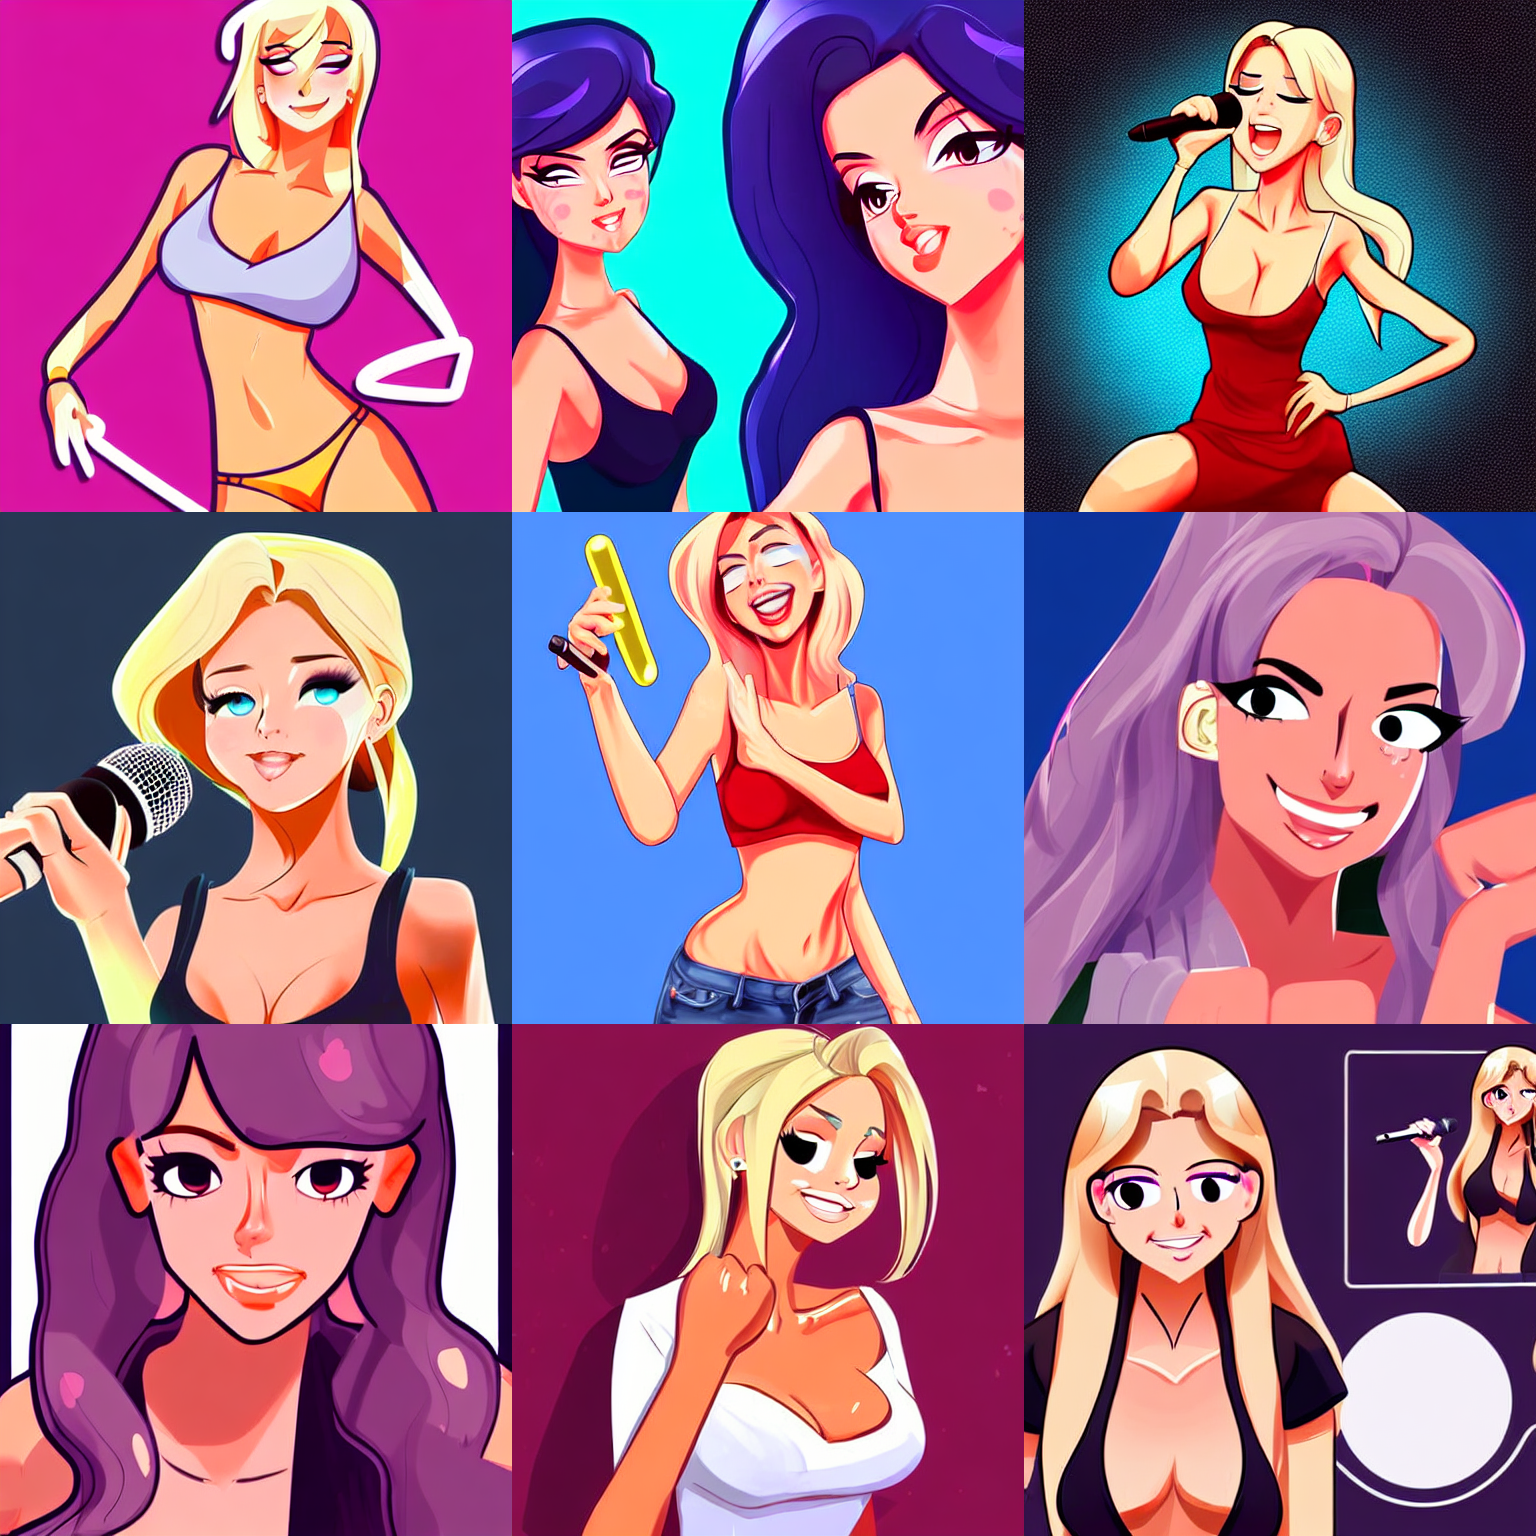

In [41]:
# Prompt and render

import time

prompt = \
"""a painting of a female singer in the style of <msa-style>, realistic, clean, toned, sharp, accurate anatomy
""" #@param {type:"string"}
# a painting of two girls scared in the style of <msa-style>, accurate, clean and smooth, toned, sharp, 8k, correct anatomy, realistic, render, highly detailed


t0 = time.time()
tz = t0
num_samples = 3 #@param {type:"number"}
num_rows = 3 #@param {type:"number"}

all_images = [] 
for _ in range(num_rows):
    images = pipe([prompt] * num_samples, num_inference_steps=200, guidance_scale=13).images
    all_images.extend(images)
    print(f"Image generated in: {time.time() - t0}")
    t0 = time.time()
    
print(f"Total time taken: {time.time() - tz}")

grid = image_grid(all_images, num_samples, num_rows)
grid